# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA    
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', dtype={18:'str', 19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', dtype={18:'str', 19:'str'})

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
# Drop the extra column of customers dataset.
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 535.2+ MB


In [8]:
cust_per_missing = pd.DataFrame(customers.isnull().sum()/customers.shape[0])

In [9]:
# Choose some columns where there are no or few missing values
cust_per_missing.sort_values(0,ascending=True).head(50)

,0
LNR,0.0
D19_WEIN_FEINKOST,0.0
D19_VOLLSORTIMENT,0.0
D19_VERSICHERUNGEN,0.0
D19_VERSI_ONLINE_DATUM,0.0
D19_VERSI_OFFLINE_DATUM,0.0
D19_VERSI_DATUM,0.0
D19_VERSI_ANZ_24,0.0
D19_VERSI_ANZ_12,0.0
D19_VERSAND_REST,0.0


SEMIO_FAM
FINANZ_HAUSBAUER
FINANZ_ANLEGER
D19_VERSI_DATUM
SEMIO_KAEM
SEMIO_SOZ
ALTER_KIND4


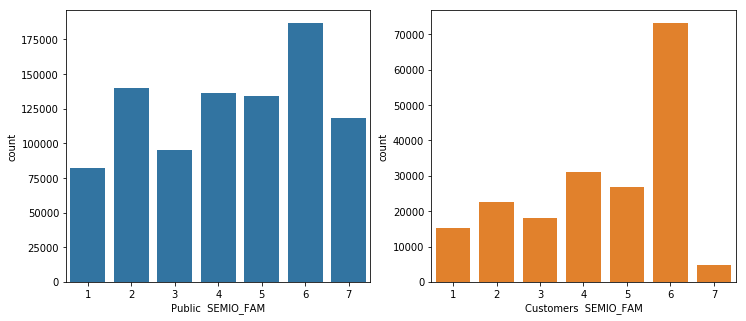

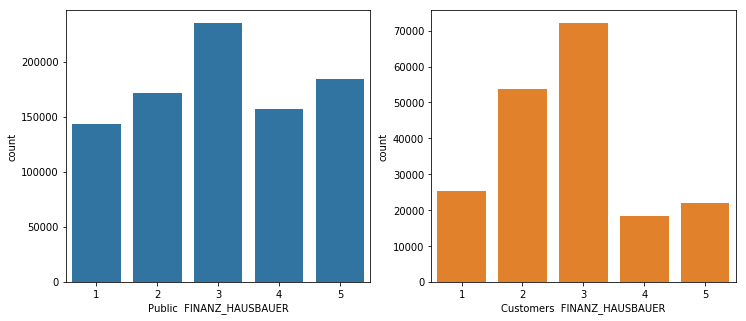

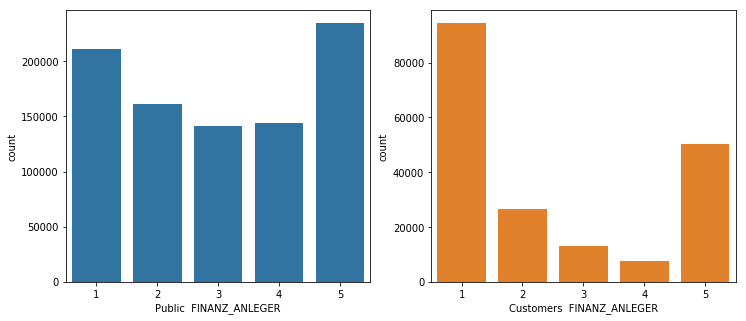

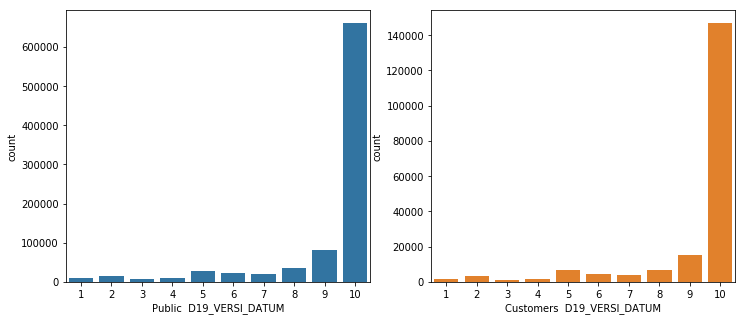

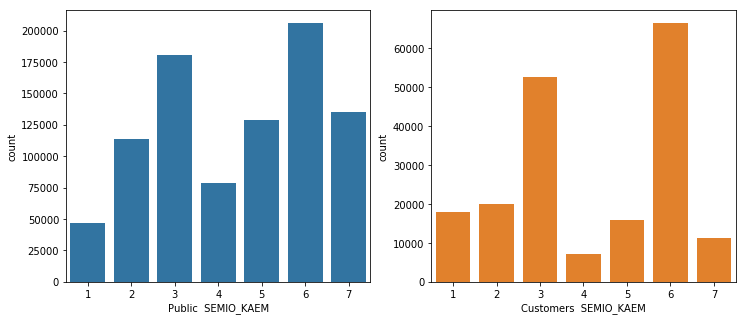

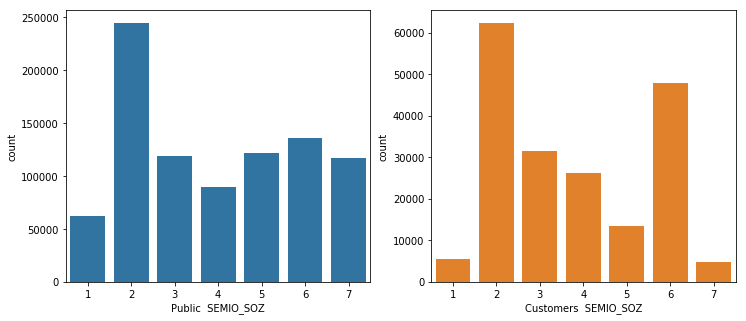

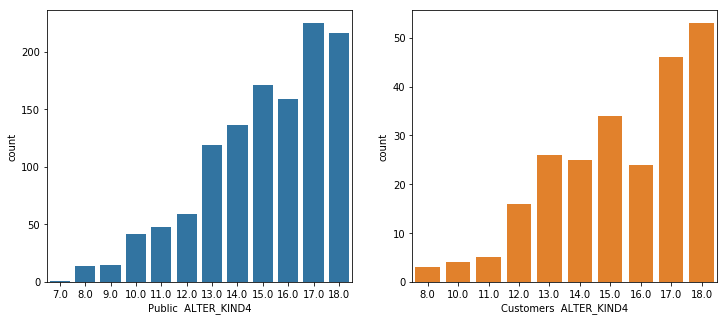

In [10]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols =["SEMIO_FAM","FINANZ_HAUSBAUER","FINANZ_ANLEGER","D19_VERSI_DATUM","SEMIO_KAEM","SEMIO_SOZ", "ALTER_KIND4"] #
for i in range(len(cols)):
    print(cols[i])
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1) #create subplots
    df_azdias = azdias[cols[i]]  #reshape images
    sns.countplot(df_azdias, color = sns.color_palette()[0]);
    plt.xlabel("Public  "+cols[i])
    
    plt.subplot(1,2,2)
    df_customers = customers[cols[i]]
    sns.countplot(df_customers, color = sns.color_palette()[1]);
    plt.xlabel("Customers  "+cols[i])
    plt.savefig(cols[i]+".png")

In [11]:
# check which columns contain 'X' or 'XX' in the population dataset
for col in azdias.columns:
    if ('X' in set(azdias[col].unique())) or ('XX' in set(azdias[col].unique())):
        print(col)

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015


('X', 'XX') in columns CAMEO_DEU_2015, CAMEO_DEUG_2015, CAMEO_INTL_2015 represents missing values, which will be converted into np.nan.

## Part 0.1 Data Processing

0.1.1 Data Processing for Azdiaz data

Look at dictionary files and encode missing values to nan's

In [12]:
# read in feature info file
feat_info_level = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx')
print(feat_info_level.head())
print('***')
print(feat_info_level.shape)

   Unnamed: 0 Information level             Attribute  \
0         NaN               NaN              AGER_TYP   
1         NaN            Person  ALTERSKATEGORIE_GROB   
2         NaN               NaN             ANREDE_KZ   
3         NaN               NaN         CJT_GESAMTTYP   
4         NaN               NaN     FINANZ_MINIMALIST   

                                         Description  \
0                                 best-ager typology   
1                      age through prename analysis    
2                                             gender   
3  Customer-Journey-Typology relating to the pref...   
4         financial typology: low financial interest   

                                    Additional notes  
0  in cooperation with Kantar TNS; the informatio...  
1  modelled on millions of first name-age-referen...  
2                                                NaN  
3  relating to the preferred information, marketi...  
4  Gfk-Typology based on a representative hou

In [13]:
# read in feature info file
feat_info_val = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', usecols = "B:E")

print(feat_info_val.head())
print('***')
print(feat_info_val.shape)

  Attribute         Description Value                     Meaning
0  AGER_TYP  best-ager typology    -1                     unknown
1       NaN                 NaN     0  no classification possible
2       NaN                 NaN     1             passive elderly
3       NaN                 NaN     2            cultural elderly
4       NaN                 NaN     3   experience-driven elderly
***
(2258, 4)


I have had a quick look ahead and notice that there where a large number of feature not pick up between the list and azdias due to a prefix in the 'D19' column. As there is non-overlaping features these mostly belonged to transaction-related features.

In [14]:
feat_info_val['Attribute'] = feat_info_val['Attribute'].fillna(method='ffill')
feat_info_val['Attribute'] = feat_info_val['Attribute'].str.replace('_RZ','')
feat_info_val['Attribute'] = feat_info_val['Attribute'].replace(to_replace = 'SOHO_FLAG', value ='SOHO_KZ')

In [15]:
#filter for only unknowns
feat_info_val = feat_info_val[(feat_info_val['Meaning'].str.contains('unknown') | feat_info_val['Meaning'].str.contains('no '))]
feat_info_val.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown


In [16]:
#create a list for column names
feat_list = feat_info_val['Attribute'].tolist()
feat_list

['AGER_TYP',
 'AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'BALLRAUM',
 'BIP_FLAG',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19

In [17]:
#look to see if there are difference between feat_list and azdias
diff_feat_azd = list(set(feat_list)- set(azdias))
print('There are {} features in feat_list that are not documented in azdias:'.format(len(diff_feat_azd)))
print(diff_feat_azd)
print('***')

There are 8 features in feat_list that are not documented in azdias:
['D19_KK_KUNDENTYP', 'HAUSHALTSSTRUKTUR', 'KBA13_CCM_1400_2500', 'WACHSTUMSGEBIET_NB', 'GEOSCORE_KLS7', 'D19_BUCH', 'BIP_FLAG', 'CAMEO_DEUINTL_2015']
***


In [18]:
#look to see if there are difference between feat_list and customer
diff_feat_cust = list(set(feat_list)- set(customers))
print('Features in feat_list that are not in azdias:')
print(len(diff_feat_cust))
print(diff_feat_cust)
print('***')

Features in feat_list that are not in azdias:
8
['D19_KK_KUNDENTYP', 'HAUSHALTSSTRUKTUR', 'KBA13_CCM_1400_2500', 'WACHSTUMSGEBIET_NB', 'GEOSCORE_KLS7', 'D19_BUCH', 'BIP_FLAG', 'CAMEO_DEUINTL_2015']
***


In [19]:
#look to see if the is a difference between azdias and feat_list
diff_azd_feat = list(set(azdias)- set(feat_list))
print('There are {} features in azdias that are not documented in feat_list:'. format(len(diff_azd_feat)))
print(diff_azd_feat)
print('***')

There are 82 features in azdias that are not documented in feat_list:
['KBA13_ANTG3', 'D19_VERSI_OFFLINE_DATUM', 'RT_SCHNAEPPCHEN', 'UMFELD_ALT', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'CJT_TYP_1', 'KBA13_ANTG1', 'ARBEIT', 'VHA', 'ANZ_TITEL', 'KBA13_GBZ', 'CJT_TYP_2', 'LNR', 'EINGEZOGENAM_HH_JAHR', 'KBA13_ANTG4', 'EXTSEL992', 'ANZ_PERSONEN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_VERSI_ONLINE_DATUM', 'DSL_FLAG', 'GREEN_AVANTGARDE', 'MOBI_RASTER', 'D19_VERSI_DATUM', 'MOBI_REGIO', 'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND1', 'VK_ZG11', 'AKT_DAT_KL', 'MIN_GEBAEUDEJAHR', 'ALTER_KIND3', 'KBA13_KMH_210', 'GFK_URLAUBERTYP', 'GEBURTSJAHR', 'D19_SOZIALES', 'KBA13_ANZAHL_PKW', 'KBA13_BAUMAX', 'UNGLEICHENN_FLAG', 'KK_KUNDENTYP', 'ONLINE_AFFINITAET', 'D19_TELKO_ONLINE_QUOTE_12', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'CJT_TYP_6', 'FIRMENDICHTE', 'EINGEFUEGT_AM', 'KONSUMNAEHE', 'VK_DHT4A', 'RT_UEBERGROESSE', 'GEMEINDETYP', 'ALTER_KIND4', 'CJT_TYP_5', 'D19_BUCH_CD', 'LP_

In [20]:
#look to see if the is a difference between customer and feat_list
diff_cust_feat = list(set(customers)- set(feat_list))
print('Features in azdias that are not in feat_list:')
print(len(diff_cust_feat))
print(diff_cust_feat)
print('***')

Features in azdias that are not in feat_list:
82
['KBA13_ANTG3', 'D19_VERSI_OFFLINE_DATUM', 'RT_SCHNAEPPCHEN', 'UMFELD_ALT', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'CJT_TYP_1', 'KBA13_ANTG1', 'ARBEIT', 'VHA', 'ANZ_TITEL', 'KBA13_GBZ', 'CJT_TYP_2', 'LNR', 'EINGEZOGENAM_HH_JAHR', 'KBA13_ANTG4', 'EXTSEL992', 'ANZ_PERSONEN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_VERSI_ONLINE_DATUM', 'DSL_FLAG', 'GREEN_AVANTGARDE', 'MOBI_RASTER', 'D19_VERSI_DATUM', 'MOBI_REGIO', 'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND1', 'VK_ZG11', 'AKT_DAT_KL', 'MIN_GEBAEUDEJAHR', 'ALTER_KIND3', 'KBA13_KMH_210', 'GFK_URLAUBERTYP', 'GEBURTSJAHR', 'D19_SOZIALES', 'KBA13_ANZAHL_PKW', 'KBA13_BAUMAX', 'UNGLEICHENN_FLAG', 'KK_KUNDENTYP', 'ONLINE_AFFINITAET', 'D19_TELKO_ONLINE_QUOTE_12', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'CJT_TYP_6', 'FIRMENDICHTE', 'EINGEFUEGT_AM', 'KONSUMNAEHE', 'VK_DHT4A', 'RT_UEBERGROESSE', 'GEMEINDETYP', 'ALTER_KIND4', 'CJT_TYP_5', 'D19_BUCH_CD', 'LP_FAMILIE_FEIN', 'STRUK

In [21]:
#confirm difference between customer and azdias
diff_customers_azdias = list(set(customers) - set(azdias))
print('Features in customers that are not in azdias:')
print(len(diff_customers_azdias))
print(diff_customers_azdias)
print('***')

Features in customers that are not in azdias:
0
[]
***


In [22]:
#confirm difference between azdias and customers
diff_customers_azdias = list(set(azdias) - set(customers))
print('Features in azdias that are not in customers:')
print(len(diff_customers_azdias))
print(diff_customers_azdias)
print('***')

Features in azdias that are not in customers:
0
[]
***


Convert feature dictionary into disctionary to encode nan's 

In [23]:
feat_info_val = feat_info_val[~feat_info_val['Attribute'].isin(diff_feat_azd)]

In [24]:
#convert missing and unknow values to a list of string
unknowns = []
for attribute in feat_info_val['Attribute'].unique():
    string_value = feat_info_val.loc[feat_info_val['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    string_value = string_value.split(',')
    unknowns.append(string_value)
    
unknowns = pd.concat([pd.Series(feat_info_val['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['Attribute', 'missing_or_unknown']

In [25]:
feat_info = unknowns
feat_info.head()

,Attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]


In [26]:
# split data into column to have nan's encoded and once that cannot be encoded
azdias_missing = azdias[(diff_azd_feat)]
azdias.drop(diff_azd_feat, axis =1, inplace = True)

customers_missing = customers[(diff_cust_feat)]
customers.drop(diff_cust_feat, axis =1, inplace = True)
    

In [27]:
print(azdias.columns)
print(azdias_missing.columns)

Index(['AGER_TYP', 'ALTER_HH', 'BALLRAUM', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       ...
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=284)
Index(['KBA13_ANTG3', 'D19_VERSI_OFFLINE_DATUM', 'RT_SCHNAEPPCHEN',
       'UMFELD_ALT', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_GROB', 'CJT_TYP_1', 'KBA13_ANTG1', 'ARBEIT', 'VHA',
       'ANZ_TITEL', 'KBA13_GBZ', 'CJT_TYP_2', 'LNR', 'EINGEZOGENAM_HH_JAHR',
       'KBA13_ANTG4', 'EXTSEL992', 'ANZ_PERSONEN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'D19_VERSI_ONLINE_DATUM', 'DSL_FLAG',
       'GREEN_AVANTGARDE', 'MOBI_RASTER', 'D19_VERSI_DATUM', 'MOBI_REGIO',
       'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND1', 'VK_ZG11', 'AKT_DAT_KL',
       'MIN_GEBAEUDEJ

In [28]:
# Converting the unknown values to NaNs in the dataset
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info['Attribute']).to_dict()
azdias[azdias.isin(missing_values)] = np.nan
print(azdias.shape)
print('***')
print(azdias.head())
print('***')

(891221, 284)
***
   AGER_TYP  ALTER_HH  BALLRAUM CAMEO_DEUG_2015  CJT_GESAMTTYP  \
0       NaN       NaN       NaN             NaN            2.0   
1       NaN       NaN       6.0               8            5.0   
2       NaN      17.0       2.0               4            3.0   
3       2.0      13.0       4.0               2            2.0   
4       NaN      20.0       2.0               6            5.0   

   D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  \
0                NaN                NaN               NaN                NaN   
1                NaN                NaN               NaN                NaN   
2                NaN                NaN               NaN                NaN   
3                NaN                NaN               NaN                NaN   
4                3.0                5.0               5.0                1.0   

   D19_BANKEN_GROSS          ...           SHOPPER_TYP  SOHO_KZ  TITEL_KZ  \
0               NaN        

In [29]:
azdias = pd.concat([azdias,azdias_missing], axis = 1)
print(azdias.head())
print('***')
print(azdias.shape)
print('***')
print(azdias.columns)

   AGER_TYP  ALTER_HH  BALLRAUM CAMEO_DEUG_2015  CJT_GESAMTTYP  \
0       NaN       NaN       NaN             NaN            2.0   
1       NaN       NaN       6.0               8            5.0   
2       NaN      17.0       2.0               4            3.0   
3       2.0      13.0       4.0               2            2.0   
4       NaN      20.0       2.0               6            5.0   

   D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  \
0                NaN                NaN               NaN                NaN   
1                NaN                NaN               NaN                NaN   
2                NaN                NaN               NaN                NaN   
3                NaN                NaN               NaN                NaN   
4                3.0                5.0               5.0                1.0   

   D19_BANKEN_GROSS     ...       ANZ_HH_TITEL  RT_KEIN_ANREIZ  \
0               NaN     ...                NaN          

In [30]:
# Converting the unknown values to NaNs in the dataset
customers[customers.isin(missing_values)] = np.nan
print(customers.shape)
print('***')
print(customers.head())
print('***')

(191652, 284)
***
   AGER_TYP  ALTER_HH  BALLRAUM CAMEO_DEUG_2015  CJT_GESAMTTYP  \
0       2.0      10.0       3.0               1            5.0   
1       NaN      11.0       NaN             NaN            NaN   
2       NaN       6.0       7.0               5            2.0   
3       1.0       8.0       7.0               4            2.0   
4       NaN      20.0       3.0               7            6.0   

   D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  \
0                NaN                NaN               NaN                NaN   
1                NaN                1.0               6.0                NaN   
2                NaN                NaN               NaN                NaN   
3                NaN                NaN               NaN                NaN   
4                1.0                2.0               3.0                5.0   

   D19_BANKEN_GROSS          ...           SHOPPER_TYP  SOHO_KZ  TITEL_KZ  \
0               NaN        

In [31]:
customers = pd.concat([customers,customers_missing], axis = 1)
print(customers.head())
print('***')
print(customers.shape)
print('***')
print(customers.columns)

   AGER_TYP  ALTER_HH  BALLRAUM CAMEO_DEUG_2015  CJT_GESAMTTYP  \
0       2.0      10.0       3.0               1            5.0   
1       NaN      11.0       NaN             NaN            NaN   
2       NaN       6.0       7.0               5            2.0   
3       1.0       8.0       7.0               4            2.0   
4       NaN      20.0       3.0               7            6.0   

   D19_BANKEN_ANZ_12  D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  \
0                NaN                NaN               NaN                NaN   
1                NaN                1.0               6.0                NaN   
2                NaN                NaN               NaN                NaN   
3                NaN                NaN               NaN                NaN   
4                1.0                2.0               3.0                5.0   

   D19_BANKEN_GROSS     ...       ANZ_HH_TITEL  RT_KEIN_ANREIZ  \
0               NaN     ...                0.0          

0.1.2 Dropping columns with to much missing data 

In [32]:
# replacing values for CAMEO_DEUG_2015 and CAMEO
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X',-1)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX',-1)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace('X',-1)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace('XX',-1)

In [33]:
# Convert row input strings to float
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(float)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(float)

In [34]:
# function to look at the statistics of the feature 
def build_feat_info(df):

   return pd.DataFrame({'value_count': [df[x].count() for x in  df.columns],'value_distinct' : [df[x].unique().shape[0] for x in  df.columns],'num_nans':  [df[x].isnull().sum() for x in  df.columns],'percent_nans' : [round(df[x].isnull().sum()/df[x].shape[0], 3) for x in  df.columns],
    },  index = df.columns)    


In [35]:
# look a statistical fetures 
feat_info_azdias =  build_feat_info(azdias)
feat_info_azdias.sort_values(by=['percent_nans'], ascending=False)

,value_count,value_distinct,num_nans,percent_nans
ALTER_KIND4,1205,13,890016,0.999
TITEL_KZ,2160,6,889061,0.998
ALTER_KIND3,6170,16,885051,0.993
SOHO_KZ,6888,2,884333,0.992
D19_TELKO_ONLINE_DATUM,8203,10,883018,0.991
D19_BANKEN_LOKAL,16476,8,874745,0.982
D19_BANKEN_OFFLINE_DATUM,19686,10,871535,0.978
ALTER_KIND2,29499,18,861722,0.967
D19_TELKO_ANZ_12,33231,7,857990,0.963
D19_DIGIT_SERV,33560,8,857661,0.962


In [36]:
# look a statistical fetures 
feat_info_customers =  build_feat_info(customers)
feat_info_customers.sort_values(by=['percent_nans'], ascending=False)

,value_count,value_distinct,num_nans,percent_nans
ALTER_KIND4,236,11,191416,0.999
SOHO_KZ,1431,2,190221,0.993
ALTER_KIND3,1275,15,190377,0.993
D19_TELKO_ONLINE_DATUM,2136,10,189516,0.989
TITEL_KZ,2312,5,189340,0.988
D19_BANKEN_LOKAL,4305,8,187347,0.978
ALTER_KIND2,5100,18,186552,0.973
D19_BANKEN_ONLINE_QUOTE_12,6794,10,184858,0.965
D19_TELKO_ANZ_12,7185,7,184467,0.963
D19_BANKEN_OFFLINE_DATUM,7450,10,184202,0.961


In [37]:
# See how much missing data there is in each column of the dataset.
missing_col_azdias = azdias.isnull().sum()/ azdias.shape[0]

In [38]:
missing_col_customers = customers.isnull().sum()/ customers.shape[0]

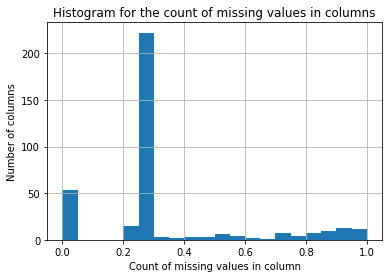

In [39]:
missing_col_customers.hist(bins = 20)
plt.xlabel('Count of missing values in column')
plt.ylabel('Number of columns')
plt.title('Histogram for the count of missing values in columns')
plt.grid(True)
plt.show()

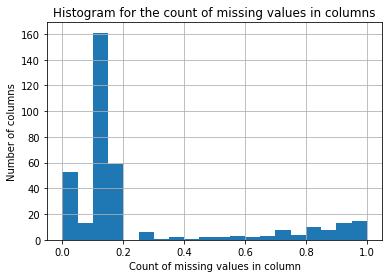

In [40]:
missing_col_azdias.hist(bins = 20)
plt.xlabel('Count of missing values in column')
plt.ylabel('Number of columns')
plt.title('Histogram for the count of missing values in columns')
plt.grid(True)
plt.show()

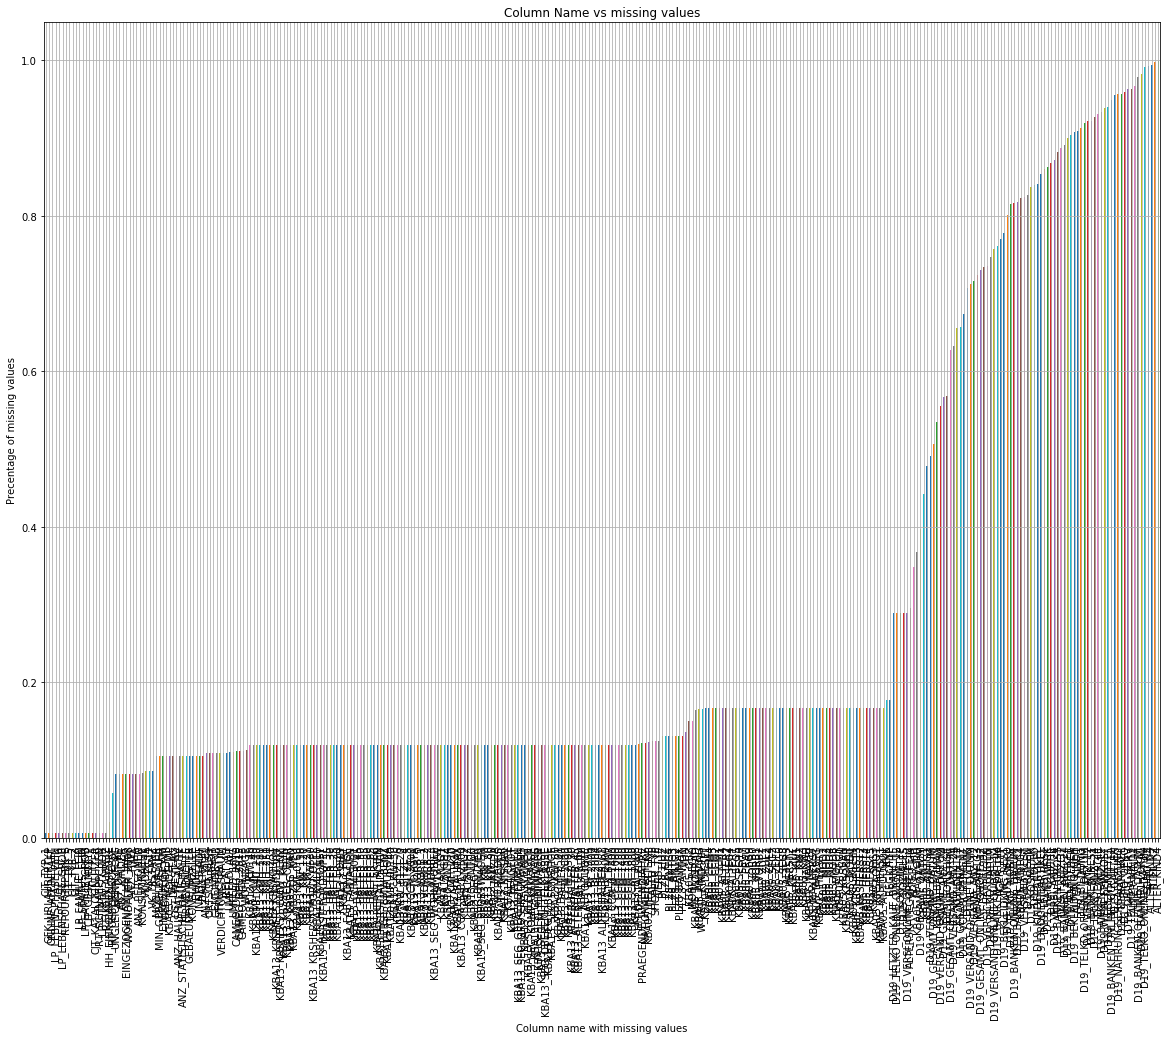

In [41]:
sorted_missing_col= missing_col_azdias[missing_col_azdias>0]
sorted_missing_col.sort_values(inplace = True)
sorted_missing_col.plot.bar(figsize=(20,15))
plt.xlabel('Column name with missing values')
plt.ylabel('Precentage of missing values')
plt.grid(True)
plt.title('Column Name vs missing values')
plt.show()

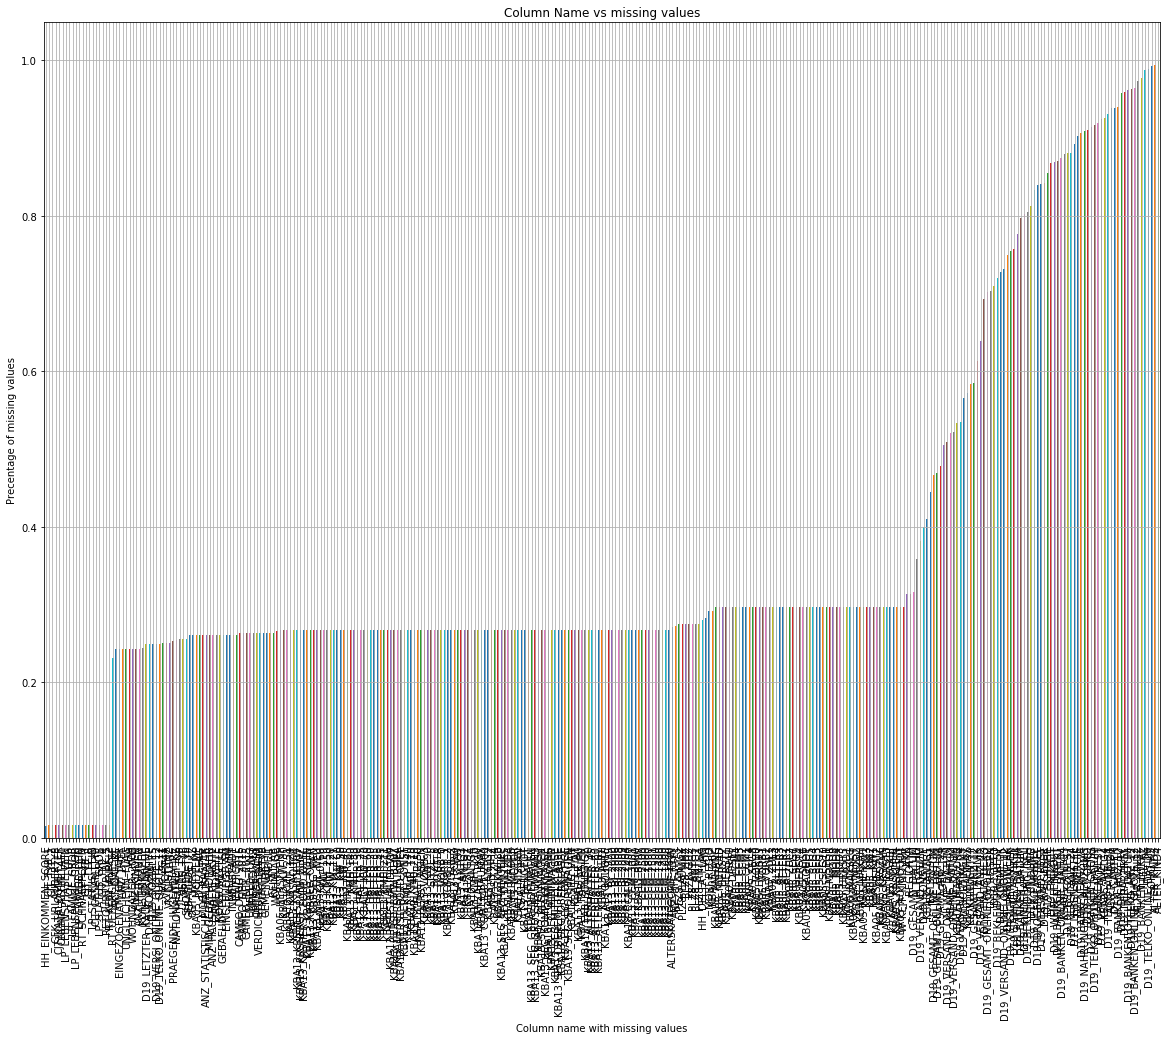

In [42]:
sorted_missing_col= missing_col_customers[missing_col_customers>0]
sorted_missing_col.sort_values(inplace = True)
sorted_missing_col.plot.bar(figsize=(20,15))
plt.xlabel('Column name with missing values')
plt.ylabel('Precentage of missing values')
plt.grid(True)
plt.title('Column Name vs missing values')
plt.show()

In [43]:
#look to see if there are difference between missing data columns in each data set with 30% missing data 
missing_col_customers3 = pd.DataFrame(missing_col_customers[missing_col_customers>.4])
missing_col_azdias3 =pd.DataFrame(missing_col_azdias[missing_col_azdias>.4])

print(list(set(missing_col_customers3.index) - set(missing_col_azdias3.index)))
print(list(set(missing_col_azdias3.index) - set(missing_col_customers3.index)))

['KBA05_MAXVORB']
['D19_SONSTIGE', 'D19_VERSAND_DATUM']


In [44]:
missing_col_updated =  pd.concat([missing_col_customers3, missing_col_azdias3], axis=1, join='inner')
print(missing_col_updated.shape)


(69, 2)


In [45]:
# Remove the columns with large amounts of missing data 
azdias.drop(missing_col_updated.index, axis=1, inplace=True)

In [46]:
print(missing_col_updated.shape)
print('***')
print(azdias.shape)

(69, 2)
***
(891221, 297)


0.1.3 Dropping rows with to much missing data 

In [47]:
# calculate the values of missing values per individual
missing_per_row = azdias.isnull().sum(axis=1) / azdias.shape[1]

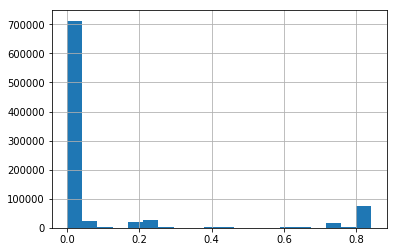

In [48]:
missing_per_row.hist(bins = 20)

In [49]:
#Split data set into 2 subset based on missing row data
def split_dataset(df, missing_per_row, threshold=.3):
    """
    Splits data into two subsets based on the missing values per row.

    INPUT:
    - df (DataFrame): DataFrame to be split
    - missing_per_row: calculated percentage of missing values per row
    - threshold (float): threshold as decision criteria for splitting

    OUTPUT:
    - DataFrame: DataFrame with a smaller percentage of missing values than the threshold 
    - DataFrame: DataFrame with a higher percentage of missing values than the threshold
    """
    
    above_th = df[missing_per_row <= threshold]
    below_th = df[missing_per_row > threshold]
    return above_th, below_th
    
azdias_low, azdias_high = split_dataset(azdias, missing_per_row)


In [50]:
# look at shape and amount to total is in each dataframe
print(azdias_low.shape)
print(azdias_low.shape[0]/azdias.shape[0])
print('***')
print(azdias_high.shape)
print(azdias_high.shape[0]/azdias.shape[0])

(785337, 297)
0.8811922070956586
***
(105884, 297)
0.11880779290434135


0.1.4 Engineer Features

In [51]:
# look at data types to convert object to numbers
azdias_low.dtypes.value_counts()

float64    260
int64       33
object       4
dtype: int64

In [52]:
def impute_na(df, variable):
    '''
    input: 
            df: input dataframe to be imputed
            variable: the column from the dataframe you want to perform imputation
    '''
    # find most frequent category
    most_frequent_category = df.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    # replace NA
    df[variable].fillna(most_frequent_category, inplace=True)

In [53]:
nan_cols = azdias_low.columns[azdias_low.isnull().any()].tolist()

In [54]:
for col in nan_cols:
    impute_na(azdias_low, col)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [55]:
azdias_low.isnull().sum()

ALTER_HH                     0
BALLRAUM                     0
CAMEO_DEUG_2015              0
CJT_GESAMTTYP                0
D19_GESAMT_DATUM             0
D19_SONSTIGE                 0
D19_VERSAND_DATUM            0
EWDICHTE                     0
FINANZ_ANLEGER               0
FINANZ_HAUSBAUER             0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_UNAUFFAELLIGER        0
FINANZ_VORSORGER             0
FINANZTYP                    0
GEBAEUDETYP                  0
HEALTH_TYP                   0
HH_EINKOMMEN_SCORE           0
INNENSTADT                   0
KBA05_ALTER1                 0
KBA05_ALTER2                 0
KBA05_ALTER3                 0
KBA05_ALTER4                 0
KBA05_ANHANG                 0
KBA05_AUTOQUOT               0
KBA05_CCM1                   0
KBA05_CCM2                   0
KBA05_CCM3                   0
KBA05_CCM4                   0
KBA05_DIESEL                 0
                            ..
RT_UEBERGROESSE              0
GEMEINDE

In [56]:
object_columns = azdias_low.select_dtypes(include=[np.object])
object_columns.head()

,OST_WEST_KZ,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,CAMEO_DEU_2015
1,W,D19_UNBEKANNT,1992-02-10 00:00:00,8A
2,W,D19_UNBEKANNT,1992-02-12 00:00:00,4C
3,W,D19_UNBEKANNT,1997-04-21 00:00:00,2A
4,W,D19_SCHUHE,1992-02-12 00:00:00,6B
5,W,D19_ENERGIE,1992-02-12 00:00:00,8C


In [57]:
# engineer year variable from EINGEFUEGT_AM
azdias_low['EINGEFUEGT_AM_YEAR'] = azdias_low['EINGEFUEGT_AM'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year)
azdias_low['EINGEFUEGT_AM_MONTH'] = azdias_low['EINGEFUEGT_AM'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month)
azdias_low[['EINGEFUEGT_AM_YEAR', 'EINGEFUEGT_AM_MONTH']].head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,EINGEFUEGT_AM_YEAR,EINGEFUEGT_AM_MONTH
1,1992,2
2,1992,2
3,1997,4
4,1992,2
5,1992,2


In [58]:
# create dummy variables for D19_LETZTER_KAUF_BRANCHE and CAMEO_DEU_2015
azdias_low = pd.get_dummies(azdias_low, prefix = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015', 'OST_WEST_KZ'], columns = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015', 'OST_WEST_KZ'])


In [59]:
azdias_low.drop(['EINGEFUEGT_AM'], axis =1, inplace = True)

In [60]:
azdias_low.dtypes.value_counts()

float64    260
uint8       82
int64       35
dtype: int64

In [61]:
print(azdias_low.shape)
print('***')
print(azdias_low.head())

(785337, 377)
***
   ALTER_HH  BALLRAUM  CAMEO_DEUG_2015  CJT_GESAMTTYP  D19_GESAMT_DATUM  \
1      18.0       6.0              8.0            5.0               9.0   
2      17.0       2.0              4.0            3.0               9.0   
3      13.0       4.0              2.0            2.0               9.0   
4      20.0       2.0              6.0            5.0               1.0   
5      10.0       6.0              8.0            2.0               3.0   

   D19_SONSTIGE  D19_VERSAND_DATUM  EWDICHTE  FINANZ_ANLEGER  \
1           6.0                9.0       3.0               5   
2           6.0                9.0       4.0               2   
3           6.0                9.0       2.0               2   
4           4.0                1.0       5.0               1   
5           6.0                9.0       2.0               2   

   FINANZ_HAUSBAUER      ...        CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  \
1                 5      ...                        0                 

In [62]:
scaler = StandardScaler()

In [63]:
# Apply feature scaling to the population  data.
azdias_low = pd.DataFrame(scaler.fit_transform(azdias_low), columns = azdias_low.columns)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [64]:
customers.shape

(191652, 366)

In [65]:
customers.head(10)

,AGER_TYP,ALTER_HH,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,...,ANZ_HH_TITEL,RT_KEIN_ANREIZ,D19_VERSI_ONLINE_QUOTE_12,LP_STATUS_FEIN,VHN,KONSUMZELLE,ANZ_HAUSHALTE_AKTIV,CJT_KATALOGNUTZER,D19_KONSUMTYP_MAX,UMFELD_JUNG
0,2.0,10.0,3.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,10.0,3.0,0.0,1.0,4.0,2,4.0
1,NaN,11.0,NaN,NaN,NaN,NaN,1.0,6.0,NaN,5.0,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,3,NaN
2,NaN,6.0,7.0,5.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,10.0,4.0,1.0,1.0,5.0,2,5.0
3,1.0,8.0,7.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,9.0,2.0,0.0,0.0,5.0,2,4.0
4,NaN,20.0,3.0,7.0,6.0,1.0,2.0,3.0,5.0,NaN,...,0.0,4.0,0.0,1.0,4.0,1.0,7.0,4.0,4,4.0
5,1.0,11.0,7.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,7.0,4.0,0.0,1.0,3.0,2,5.0
6,2.0,10.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,3.0,0.0,10.0,4.0,0.0,1.0,5.0,2,5.0
7,1.0,10.0,5.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,10.0,3.0,0.0,1.0,5.0,2,4.0
8,2.0,5.0,3.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,0.0,1.0,NaN,1.0,74.0,5.0,2,4.0
9,1.0,20.0,2.0,1.0,3.0,NaN,NaN,8.0,7.0,NaN,...,0.0,1.0,0.0,10.0,2.0,0.0,1.0,2.0,2,5.0


In [66]:
def drop_columns(data, columns ):
    """
   
    INPUT: 
        azdias: Population/Customer demographics DataFrame
        columns: list of columns to drop from dataframe
    OUTPUT: Datafram with column drop with large missing values
    """

    # Remove the outlier columns from the dataset
    data.drop(columns.index, axis=1, inplace=True) # dropping those columns from the data set
    

    
    
    # Return data with dropped columns
    return data

In [67]:
# Run the clean_data function on the population dataset
customers = drop_columns(customers, missing_col_updated)
print(customers.shape)
print('***')
print(customers.head())

(191652, 297)
***
   ALTER_HH  BALLRAUM  CAMEO_DEUG_2015  CJT_GESAMTTYP  D19_GESAMT_DATUM  \
0      10.0       3.0              1.0            5.0               9.0   
1      11.0       NaN              NaN            NaN               6.0   
2       6.0       7.0              5.0            2.0               NaN   
3       8.0       7.0              4.0            2.0               6.0   
4      20.0       3.0              7.0            6.0               1.0   

   D19_SONSTIGE  D19_VERSAND_DATUM  EWDICHTE  FINANZ_ANLEGER  \
0           6.0                9.0       2.0               1   
1           NaN                9.0       NaN               1   
2           6.0                NaN       4.0               1   
3           NaN                6.0       1.0               2   
4           6.0                1.0       4.0               4   

   FINANZ_HAUSBAUER     ...       ANZ_HH_TITEL  RT_KEIN_ANREIZ  \
0                 2     ...                0.0             1.0   
1             

In [68]:
missing_per_row_cust = customers.isnull().sum(axis=1)/ customers.shape[1]

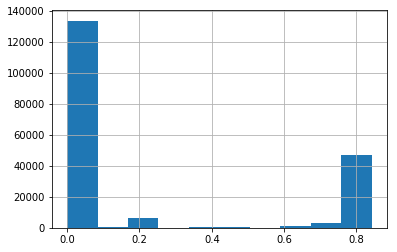

In [69]:
missing_per_row_cust.hist()

In [70]:
# run split function to split data into rows with a low number of rows missing
customers_low, customers_high = split_dataset(customers, missing_per_row_cust)

In [71]:
print(customers_low.head())

   ALTER_HH  BALLRAUM  CAMEO_DEUG_2015  CJT_GESAMTTYP  D19_GESAMT_DATUM  \
0      10.0       3.0              1.0            5.0               9.0   
2       6.0       7.0              5.0            2.0               NaN   
3       8.0       7.0              4.0            2.0               6.0   
4      20.0       3.0              7.0            6.0               1.0   
5      11.0       7.0              5.0            4.0               6.0   

   D19_SONSTIGE  D19_VERSAND_DATUM  EWDICHTE  FINANZ_ANLEGER  \
0           6.0                9.0       2.0               1   
2           6.0                NaN       4.0               1   
3           NaN                6.0       1.0               2   
4           6.0                1.0       4.0               4   
5           6.0                6.0       5.0               1   

   FINANZ_HAUSBAUER     ...       ANZ_HH_TITEL  RT_KEIN_ANREIZ  \
0                 2     ...                0.0             1.0   
2                 4     ...     

In [72]:
nan_cols = customers_low.columns[customers_low.isnull().any()].tolist()

In [73]:
for col in nan_cols:
    impute_na(customers_low, col)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [74]:
customers_low.dtypes.value_counts()

float64    260
int64       33
object       4
dtype: int64

In [75]:
def engineer (data):
    """
   
    INPUT: 
        data: Population/Customer demographics DataFrame
    OUTPUT: clean data with imputed data
    """
    # engineer year variable from EINGEFUEGT_AM
    data['EINGEFUEGT_AM_YEAR'] = data['EINGEFUEGT_AM'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year)
    data['EINGEFUEGT_AM_MONTH'] = data['EINGEFUEGT_AM'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month)
    data[['EINGEFUEGT_AM_YEAR', 'EINGEFUEGT_AM_MONTH']].head()
    
    # create dummy variables for D19_LETZTER_KAUF_BRANCHE, CAMEO_DEU_2015 and OST_WEST_KZ
    data = pd.get_dummies(data, prefix = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015', 'OST_WEST_KZ'], columns = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015', 'OST_WEST_KZ'])
    
    #drop columns
    data.drop(['EINGEFUEGT_AM'], axis =1, inplace = True)
    
    return data

In [76]:
customers_low = engineer(customers_low)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [77]:
customers_low.dtypes.value_counts()

float64    260
uint8       82
int64       35
dtype: int64

In [78]:
customers_low = pd.DataFrame(scaler.fit_transform(customers_low), columns = customers_low.columns)

In [79]:
customers_low.head()

,ALTER_HH,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_GESAMT_DATUM,D19_SONSTIGE,D19_VERSAND_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W
0,-0.686229,-0.616563,-1.401953,1.328536,1.585813,0.34668,1.034755,-1.169643,-0.599808,-0.556463,...,-0.142229,-0.125723,-0.085432,-0.080827,-0.08355,-0.118294,-0.100084,-0.029616,-0.294675,0.294675
1,-1.637480,1.275704,0.280549,-0.669692,0.026395,0.34668,1.034755,0.074550,-0.599808,0.964225,...,-0.142229,-0.125723,-0.085432,-0.080827,-0.08355,-0.118294,-0.100084,-0.029616,-0.294675,0.294675
2,-1.161855,1.275704,-0.140077,-0.669692,0.416250,0.34668,-0.024754,-1.791740,0.398518,-0.556463,...,-0.142229,-0.125723,-0.085432,-0.080827,-0.08355,-0.118294,-0.100084,-0.029616,-0.294675,0.294675
3,1.691899,-0.616563,1.121800,1.994612,-1.533023,0.34668,-1.790603,0.074550,2.395171,-0.556463,...,-0.142229,-0.125723,-0.085432,-0.080827,-0.08355,-0.118294,-0.100084,-0.029616,-0.294675,0.294675
4,-0.448416,1.275704,0.280549,0.662460,0.416250,0.34668,-0.024754,0.696646,-0.599808,0.203881,...,-0.142229,-0.125723,-0.085432,-0.080827,-0.08355,-0.118294,-0.100084,-0.029616,-0.294675,0.294675


In [80]:
# Apply PCA to the customer and azdias data.
pca = PCA()
customers_low = pca.fit_transform(customers_low)
azdias_low = pca.fit_transform(azdias_low)

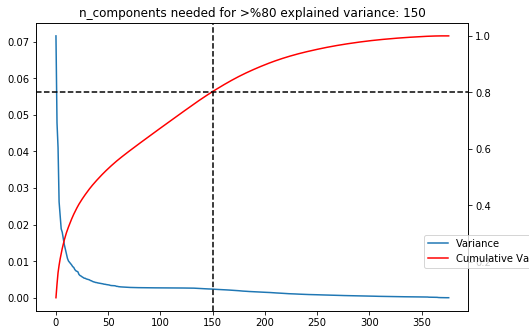

In [81]:
#Investigate the variance accounted for by each principal component.
n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.8)[0]+1) # 80% of variance selected

fig = plt.figure()
ax = fig.add_axes([0,0,1,1],True)
ax2 = ax.twinx()
ax.plot(pca.explained_variance_ratio_, label='Variance',)
ax2.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative Variance',color = 'red');
ax.set_title('n_components needed for >%80 explained variance: {}'.format(n_components));
ax.axvline(n_components, linestyle='dashed', color='black')
ax2.axhline(np.cumsum(pca.explained_variance_ratio_)[n_components], linestyle='dashed', color='black')
fig.legend(loc=(0.8,0.2));

In [82]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=60, random_state=10)
cust_pca = pca.fit_transform(customers_low)
azd_pca = pca.fit_transform(azdias_low)

In [83]:
kmeans_scores = []
for i in range(2,30,2):

    #run k-means clustering on the data 
    kmeans = MiniBatchKMeans(i)
    kmeans.fit(cust_pca)
    
    #compute the average within-cluster distances.
    kmeans_scores.append(-kmeans.score(cust_pca))

In [84]:
kmeans_scores

[26152136.31001791,
 24225210.517863873,
 23068245.553309008,
 22765214.033275492,
 22036414.849934395,
 22270200.646765199,
 21651149.62234994,
 21218783.933474101,
 20811378.708582871,
 20568876.730865326,
 20792263.472823173,
 21048947.957930014,
 20303003.59918097,
 20160360.112605598]

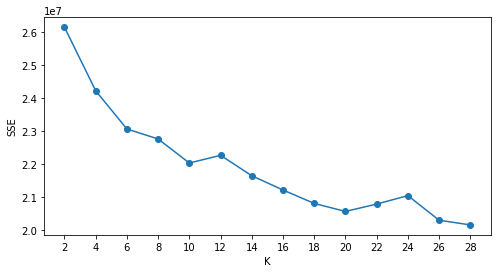

In [85]:
# Plot elbow plot
x = range(2, 30, 2)
plt.figure(figsize=(8, 4))
plt.plot(x, kmeans_scores, marker='o')
plt.xticks(x)
plt.xlabel('K')
plt.ylabel('SSE');

In [86]:
# Re-fit the k-means model with the selected number of clusters (24) and obtain
# cluster predictions for the general population demographics data.

kmeans_20 = KMeans(24, random_state=10)
clusters_pop = kmeans_20.fit_predict(cust_pca)
azdias_pop = kmeans_20.fit_predict(azd_pca)

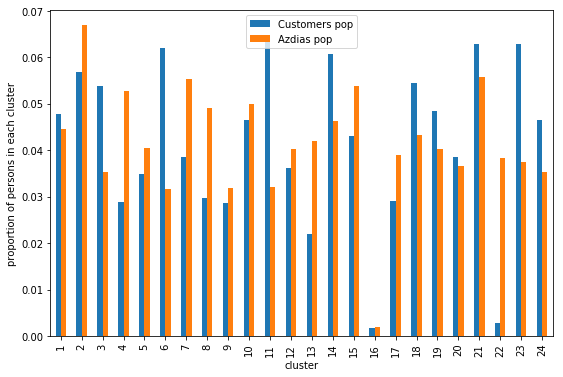

In [87]:
customers_prop = []
azdias_prop = []
x = [i+1 for i in range(24)]
for i in range(24):
    customers_prop.append((clusters_pop == i).sum()/len(clusters_pop))
    azdias_prop.append((azdias_pop == i).sum()/len(azdias_pop))


df_general = pd.DataFrame({'cluster' : x, 'Customers pop':customers_prop, 'Azdias pop': azdias_prop})

df_general.plot(x='cluster', y = ['Customers pop', 'Azdias pop'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [110]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [111]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


In [112]:
mailout_train.shape

(42962, 367)

In [113]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [114]:
mailout_train['RESPONSE'].isnull().sum()

0

In [115]:
# Imbalance of REPONSE column
vc = mailout_train['RESPONSE'].value_counts()
vc

0    42430
1      532
Name: RESPONSE, dtype: int64

In [116]:
# positive response
vc[1]/(vc[0]+vc[1])

0.012383036171500396

In [117]:
# negative response
vc[0]/(vc[0]+vc[1])

0.98761696382849962

In [118]:
# replacing values for CAMEO_DEUG_2015 and CAMEO
mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].replace('X',-1)
mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].replace('XX',-1)

In [119]:
# Convert row input strings to float
mailout_train[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = mailout_train[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(float)

In [120]:
# drop columns
mailout_train = drop_columns(mailout_train, missing_col_updated)

In [121]:
missing_per_row_mail = mailout_train.isnull().sum(axis=1)/ mailout_train.shape[1]

In [122]:
# run split function to split data into rows with a low number of rows missing
mailout_train, mail_high = split_dataset(mailout_train, missing_per_row_mail)

In [123]:
nan_cols = mailout_train.columns[mailout_train.isnull().any()].tolist()

In [124]:
for col in nan_cols:
    impute_na(mailout_train, col)

In [125]:
mailout_train.dtypes.value_counts()

float64    252
int64       42
object       4
dtype: int64

In [126]:
mailout_train= engineer(mailout_train)

In [127]:
mailout_train.dtypes.value_counts()

float64    252
uint8       82
int64       44
dtype: int64

In [128]:
mailout_train.shape

(35000, 378)

In [129]:
mailout_train.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1763,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,1771,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,1776,1.0,9.0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,1460,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,1783,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [130]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

In [131]:
# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [132]:
mailout_train_scaled = scaler.fit_transform(mailout_train)

In [133]:
mailout_train_scaled.shape

(35000, 377)

In [134]:
response.shape

(35000,)

In [135]:
#fit the classifer to data
def classify(clf, param_grid, X_train=mailout_train_scaled, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [136]:
# LogisticRegression
logreg = LogisticRegression(random_state=12)
classify(logreg, {})

0.66196920345


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
# BaggingClassifier
bac = BaggingClassifier(random_state=12)
classify(bac, {})

0.585578395527


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=12,
         verbose=0, warm_start=False)

In [138]:
# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=12)
abc_best_est = classify(abc, {})

0.752391379892


In [139]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=12)
classify(gbc, {})

0.775127653879


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=12, subsample=1.0, verbose=0,
              warm_start=False)

In [140]:
# tune with the help of GridSearchCV
gbc = GradientBoostingClassifier(random_state=12)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [4],
              'n_estimators':[210],
             }


gbc_tuned = classify(gbc, param_grid)
gbc_tuned

0.772269138106


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=210,
              presort='auto', random_state=12, subsample=1.0, verbose=0,
              warm_start=False)

In [141]:
# RandomForestClassifier
rfr = RandomForestRegressor(random_state=12)
classify(rfr, {})

0.597866568898


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=12, verbose=0, warm_start=False)

In [142]:
## tune with the help of GridSearchCV
# the result is our model that will be used with the test set
param_grid = {
    'max_depth': [4],
    'n_estimators':[210], 
    'max_features':[280]
}

rfr = RandomForestRegressor(random_state=12, n_jobs = 2)

estimator_tuned = classify(rfr, param_grid)
estimator_tuned

0.776604639286


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=280, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=210, n_jobs=2,
           oob_score=False, random_state=12, verbose=0, warm_start=False)

In [143]:
#XGBoost
#param_grid = {
#    'n_estimators':[1500],
#    'max_depth':[3],
#    'learning_rate': [0.001], 
#    'reg_lambda': [0]
#}

#estimator =  XGBRegressor(n_jobs = 2)

#estimator_tuned = classify(rfr, param_grid)
#estimator_tuned

In [144]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=12)
skf.get_n_splits(mailout_train, response)
print(skf)

StratifiedKFold(n_splits=5, random_state=12, shuffle=False)


In [145]:
#create pipeline for sclare and classifer 
def create_pipeline(clf):
    
    # Create machine learning pipeline
    pipeline = Pipeline([
        ('scale', scaler),
        ('clf', clf)
    ])
    
    return pipeline

In [146]:
#cross fold validation 
def cross_validate(clf):

    pipeline = create_pipeline(clf)
    scores = []
    i = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(mailout_train, response):
        i+=1
        print('Fold {}'.format(i))
        
        # Split the data into training and test sets
        X_train, X_test = mailout_train.iloc[train_index], mailout_train.iloc[test_index]
        y_train, y_test = response.iloc[train_index], response.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print("Score: {}".format(score))
        
    return scores

In [147]:
from sklearn.metrics import roc_auc_score

tuned_scores = cross_validate(rfr)

Fold 1
Score: 0.5790107260849541
Fold 2
Score: 0.5950375022238628
Fold 3
Score: 0.5770595463153712
Fold 4
Score: 0.5816876748953745
Fold 5
Score: 0.580818082207269


In [148]:
tuned_scoredgbc = cross_validate(gbc)

Fold 1
Score: 0.49971069000433965
Fold 2
Score: 0.49963836250542454
Fold 3
Score: 0.49971069000433965
Fold 4
Score: 0.4998553450021698
Fold 5
Score: 0.4997830175032547


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [150]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', dtype={18:'str', 19:'str'})

In [151]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 119.6+ MB


In [152]:
mailout_test.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
5,1782,2,1.0,7.0,NaN,NaN,NaN,NaN,7.0,66.0,...,4.0,9.0,10.0,7.0,6.0,9.0,3.0,6,1,4
6,1485,2,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,1.0,2.0,1.0,6.0,9.0,3.0,3,2,4
7,1519,-1,1.0,20.0,NaN,NaN,NaN,NaN,15.0,1.0,...,2.0,4.0,5.0,4.0,2.0,9.0,3.0,4,2,3
8,1835,1,1.0,19.0,NaN,NaN,NaN,NaN,13.0,2.0,...,1.0,1.0,1.0,1.0,4.0,9.0,7.0,1,2,3
9,1522,1,1.0,0.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,5.0,8.0,9.0,3.0,4.0,2.0,4,1,3


In [153]:
# replacing values for CAMEO_DEUG_2015 and CAMEO
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].replace('X',-1)
mailout_test['CAMEO_INTL_2015'] = mailout_test['CAMEO_INTL_2015'].replace('XX',-1)

In [154]:
# Convert row input strings to float
mailout_test[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = mailout_test[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(float)

In [155]:
# clean data
mailout_test = drop_columns(mailout_test, missing_col_updated )

In [156]:
nan_cols = mailout_test.columns[mailout_test.isnull().any()].tolist()

In [157]:
for col in nan_cols:
    impute_na(mailout_test, col)

In [158]:
mailout_test.dtypes.value_counts()

float64    252
int64       41
object       4
dtype: int64

In [159]:
mailout_test= engineer(mailout_test)

In [160]:
mailout_test_scaled = scaler.transform(mailout_test)

In [161]:
lnr = mailout_test.LNR

In [162]:
# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = estimator_tuned.predict(mailout_test_scaled)
response_test

array([ 0.0333813 ,  0.03175726,  0.00265264, ...,  0.0299191 ,
        0.01888174,  0.02718723])

In [163]:
response_test.shape

(42833,)

In [164]:
len(lnr)

42833

In [165]:
# generate result file for the competition
result = pd.DataFrame({'LNR':lnr, 'RESPONSE':response_test[:,]})
result.head(10)

,LNR,RESPONSE
0,1754,0.033381
1,1770,0.031757
2,1465,0.002653
3,1470,0.004454
4,1478,0.004636
5,1782,0.002476
6,1485,0.002802
7,1519,0.030271
8,1835,0.032316
9,1522,0.003878


In [166]:
result.to_csv('kaggle_results.csv', sep =',')